In [1]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

In [2]:
from utils_model_sampling import sample_models_across_time

In [3]:
# 7/2/21: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
# end cite

In [4]:
raw_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order()) # Should you run things locally?

Loading all all False 0 adult
Loading all all False 20 adult
Loading all all True 0 childes
Loading all all True 20 childes
Loading all all False 0 childes
Loading all all False 20 childes
Loading age young True 0 childes
Loading age young True 20 childes
Loading age young False 0 childes
Loading age young False 20 childes
Loading age old True 0 childes
Loading age old True 20 childes
Loading age old False 0 childes
Loading age old False 20 childes
Loading all all False 0 flat_unigram
Loading all all False 0 data_unigram


In [6]:
raw_scores_across_time['model'] # Need to select which?

# From the original analysis
original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram',
}


is_filter = True
if is_filter:
# Don't filter
    scores_across_time = raw_scores_across_time[raw_scores_across_time.model.isin(original_set_of_models)]
else:
    scores_across_time = raw_scores_across_time

In [7]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

/home/nwong/chompsky/childes/child_listening_continuation/child-listening-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
%%R
library('plyr')
# rename the models

# Do this manually for now.

model_levels = c("CHILDES BERT with tags, +-20 utts context",
                 "CHILDES BERT without tags, +-20 utts context",
                 "CHILDES BERT with tags, same utt only",
                 "CHILDES BERT without tags, same utt only",
                 "Adult BERT with tags, +-20 utts context",
                 "Adult BERT without tags, +-20 utts context",
                 "Adult BERT with tags, same utt only",
                 "Adult BERT without tags, same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, same utt only" = "CDL+OneUtt", 
                    "Adult BERT with tags, +-20 utts context" = "BERT+Context+Tags",
                    "Adult BERT without tags, +-20 utts context" = "BERT+Context",
                    "Adult BERT with tags, same utt only" = "BERT+OneUtt+Tags",
                    "Adult BERT without tags, same utt only" = "BERT+OneUtt+Tags",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')

# 10 Average Prior Surprisal

In [11]:
%%R
names(successes_across_time)

aggregate(prior_surprisal ~ model, successes_across_time, function(x){mean(-1 * log(x, 2))})

          model prior_surprisal
1 CHILDES 1gram         8.77936
2  UniformPrior        12.94837


In [12]:
# 7/15/21: Debugging help, for the "spread" cell -- not a code reference
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325

# some models and prior surprisals are the same -- why + how?

In [13]:
scores_across_time.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   0,   1,   2,
            ...
            646, 647, 648, 649, 650, 651, 652, 653, 654, 655],
           dtype='int64', length=19435)

In [14]:
which_dup.columns

NameError: name 'which_dup' is not defined

In [15]:
duplicates = scores_across_time[['model', 'prior_surprisal']].dropna().duplicated()

which_dup = scores_across_time[scores_across_time.index.isin(duplicates)].sort_values('entropy')[['model', 'prior_surprisal']]

set(which_dup['prior_surprisal']) # Mostly nan with some repeats -- why?

# There are still duplicates in here -- why? Can you just pick a different key to index on?
# Is this indicative of some kind of data loading mistaken?


{nan,
 nan,
 nan,
 nan,
 nan,
 0.0562560148537159,
 0.4780972898006439,
 0.7059495449066162,
 nan,
 nan,
 0.6362202167510986,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.000673872282923,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.0004975239381485,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.0105873653665184,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.022344646975398,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.0001265182186234,
 0.3101424872875213,
 0.4698182642459869}

In [10]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_surprisal',
'bert_token_id')], model, prior_surprisal)

head(successes_across_time_wide)

R[write to console]: Error: Each row of output must be identified by a unique combination of keys.
Keys are shared for 8956 rows:
* 1894, 4133, 6372, 8611
* 1143, 3382, 5621, 7860
* 135, 2374, 4613, 6852
* 136, 2375, 4614, 6853
* 137, 2376, 4615, 6854
* 1895, 4134, 6373, 8612
* 138, 2377, 4616, 6855
* 139, 2378, 4617, 6856
* 140, 2379, 4618, 6857
* 141, 2380, 4619, 6858
* 142, 2381, 4620, 6859
* 1896, 4135, 6374, 8613
* 143, 2382, 4621, 6860
* 144, 2383, 4622, 6861
* 145, 2384, 4623, 6862
* 146, 2385, 4624, 6863
* 147, 2386, 4625, 6864
* 148, 2387, 4626, 6865
* 1897, 4136, 6375, 8614
* 1144, 3383, 5622, 7861
* 1898, 4137, 6376, 8615
* 149, 2388, 4627, 6866
* 1899, 4138, 6377, 8616
* 1900, 4139, 6378, 8617
* 1901, 4140, 6379, 8618
* 1902, 4141, 6380, 8619
* 1903, 4142, 6381, 8620
* 1904, 4143, 6382, 8621
* 1905, 4144, 6383, 8622
* 150, 2389, 4628, 6867
* 151, 2390, 4629, 6868
* 152, 2391, 4630, 6869
* 153, 2392, 4631, 6870
* 154, 2393, 4632, 6871
* 155, 2394, 4633, 6872
* 156, 2395, 463


Error: Each row of output must be identified by a unique combination of keys.
Keys are shared for 8956 rows:
* 1894, 4133, 6372, 8611
* 1143, 3382, 5621, 7860
* 135, 2374, 4613, 6852
* 136, 2375, 4614, 6853
* 137, 2376, 4615, 6854
* 1895, 4134, 6373, 8612
* 138, 2377, 4616, 6855
* 139, 2378, 4617, 6856
* 140, 2379, 4618, 6857
* 141, 2380, 4619, 6858
* 142, 2381, 4620, 6859
* 1896, 4135, 6374, 8613
* 143, 2382, 4621, 6860
* 144, 2383, 4622, 6861
* 145, 2384, 4623, 6862
* 146, 2385, 4624, 6863
* 147, 2386, 4625, 6864
* 148, 2387, 4626, 6865
* 1897, 4136, 6375, 8614
* 1144, 3383, 5622, 7861
* 1898, 4137, 6376, 8615
* 149, 2388, 4627, 6866
* 1899, 4138, 6377, 8616
* 1900, 4139, 6378, 8617
* 1901, 4140, 6379, 8618
* 1902, 4141, 6380, 8619
* 1903, 4142, 6381, 8620
* 1904, 4143, 6382, 8621
* 1905, 4144, 6383, 8622
* 150, 2389, 4628, 6867
* 151, 2390, 4629, 6868
* 152, 2391, 4630, 6869
* 153, 2392, 4631, 6870
* 154, 2393, 4632, 6871
* 155, 2394, 4633, 6872
* 156, 2395, 4634, 6873
* 157, 2396,

In [202]:
%%R

# This only happens with the full set of results -- what to do?

# As recommended by the error output when running above cell 
rlang::last_error()
rlang::last_trace()
# end cite

<error/rlang_error>
Each row of output must be identified by a unique combination of keys.
Keys are shared for 32266 rows:
* 14200, 16340, 18480, 20620
* 14201, 16341, 18481, 20621
* 14202, 16342, 18482, 20622
* 1894, 4133, 6372, 8611, 10850, 13089
* 1143, 3382, 5621, 7860, 10099, 12338
* 15173, 17313, 19453, 21593
* 15174, 17314, 19454, 21594
* 15175, 17315, 19455, 21595
* 135, 2374, 4613, 6852, 9091, 11330
* 136, 2375, 4614, 6853, 9092, 11331
* 137, 2376, 4615, 6854, 9093, 11332
* 1895, 4134, 6373, 8612, 10851, 13090
* 138, 2377, 4616, 6855, 9094, 11333
* 139, 2378, 4617, 6856, 9095, 11334
* 140, 2379, 4618, 6857, 9096, 11335
* 141, 2380, 4619, 6858, 9097, 11336
* 142, 2381, 4620, 6859, 9098, 11337
* 15176, 17316, 19456, 21596
* 13436, 15576, 17716, 19856
* 13437, 15577, 17717, 19857
* 1896, 4135, 6374, 8613, 10852, 13091
* 15177, 17317, 19457, 21597
* 143, 2382, 4621, 6860, 9099, 11338
* 144, 2383, 4622, 6861, 9100, 11339
* 15178, 17318, 19458, 21598
* 13438, 15578, 17718, 19858
* 1

In [204]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

R[write to console]: Error in t.test.default(successes_across_time_wide[[model_name]], successes_across_time_wide[[comparison_model_name]],  : 
  not enough 'x' observations




Error in t.test.default(successes_across_time_wide[[model_name]], successes_across_time_wide[[comparison_model_name]],  : 
  not enough 'x' observations


### Posterior Surprisal Across Ages

## Note to self: Check correctness of young/old divide len stdev here

In [205]:
%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

   age         model posterior_surprisal_mean posterior_surprisal_sem
1  0.5 CHILDES 1gram                 4.245532               6.1038578
2  0.5  UniformPrior                 5.107312               6.9476077
3  1.5 CHILDES 1gram                 3.500875               0.2871633
4  1.5  UniformPrior                 4.364200               0.2620541
5  1.0 CHILDES 1gram                 5.061309               0.6194227
6  1.0  UniformPrior                 5.457510               0.5473872
7  2.5 CHILDES 1gram                 2.683053               0.1750283
8  2.5  UniformPrior                 3.566216               0.1548113
9  2.0 CHILDES 1gram                 2.777436               0.1792845
10 2.0  UniformPrior                 3.814086               0.1706898
11 3.5 CHILDES 1gram                 2.173929               0.3727655
12 3.5  UniformPrior                 3.015506               0.3333228
13 3.0 CHILDES 1gram                 2.558996               0.2154940
14 3.0  UniformPrior

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,0.5,CHILDES 1gram,4.245532,6.103858
2,0.5,UniformPrior,5.107312,6.947608
3,1.5,CHILDES 1gram,3.500875,0.287163
4,1.5,UniformPrior,4.364200,0.262054
5,1.0,CHILDES 1gram,5.061309,0.619423
6,1.0,UniformPrior,5.457510,0.547387
7,2.5,CHILDES 1gram,2.683053,0.175028
8,2.5,UniformPrior,3.566216,0.154811
9,2.0,CHILDES 1gram,2.777436,0.179284
10,2.0,UniformPrior,3.814086,0.170690


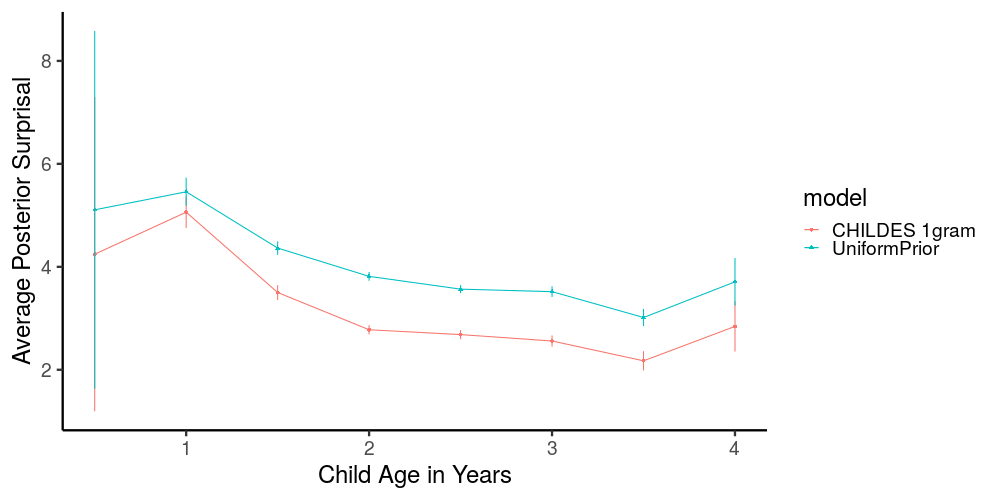

In [207]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

### Prior Surprisal Across Ages

In [160]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,prior_surprisal_mean,prior_surprisal_sem
1,0.5,"Adult BERT without tags, , +-20 utts context",4.137275,0.784281
2,0.5,"Adult BERT without tags, , same utt only",14.480383,0.713066
3,0.5,"CHILDES BERT without tags, , +-20 utts context",0.273294,0.106330
4,0.5,"CHILDES BERT without tags, , same utt only",3.174219,1.857451
5,0.5,CHILDES Unigram,8.155822,0.068798
6,0.5,Flat Unigram,12.948367,0.000000
7,1.5,"Adult BERT without tags, , +-20 utts context",5.166650,0.192258
8,1.5,"Adult BERT without tags, , same utt only",8.642180,0.205887
9,1.5,"CHILDES BERT without tags, , +-20 utts context",3.421072,0.162766
10,1.5,"CHILDES BERT without tags, , same utt only",6.126683,0.176624


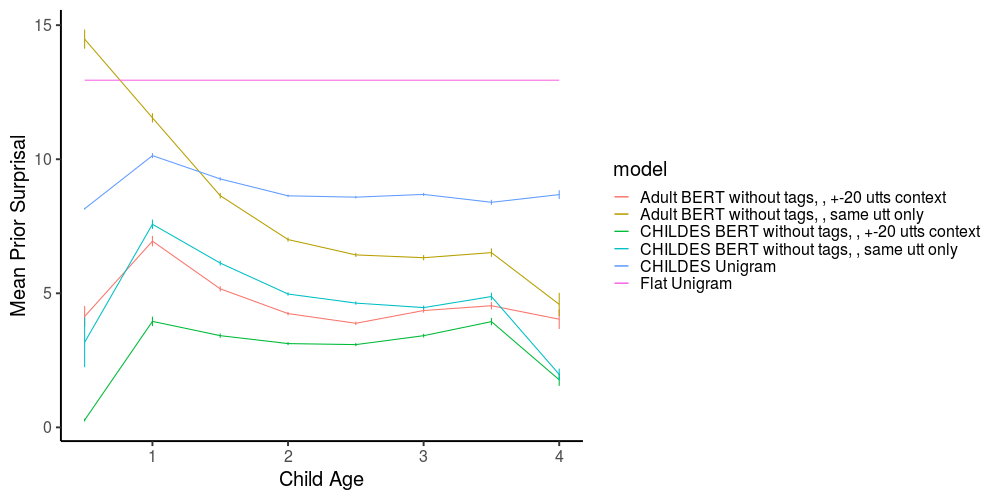

In [161]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [219]:
scores_across_time_short.set.value_counts()

success    13434
failure     6001
Name: set, dtype: int64

### Posterior Entropy Stratified by Successes vs. Failures

In [163]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,0.5,"Adult BERT without tags, , +-20 utts context",failure,3.833877,0.302392
2,0.5,"Adult BERT without tags, , +-20 utts context",success,1.256273,1.157004
3,0.5,"Adult BERT without tags, , same utt only",failure,4.108678,0.459334
4,0.5,"Adult BERT without tags, , same utt only",success,2.715195,0.332250
5,0.5,"CHILDES BERT without tags, , +-20 utts context",failure,3.572890,0.344146
...,...,...,...,...,...
86,4.0,"Adult BERT without tags, , same utt only",success,0.907204,0.236242
87,4.0,"CHILDES BERT without tags, , +-20 utts context",success,0.276949,0.124973
88,4.0,"CHILDES BERT without tags, , same utt only",success,0.301997,0.125455
89,4.0,CHILDES Unigram,success,1.994985,0.251594


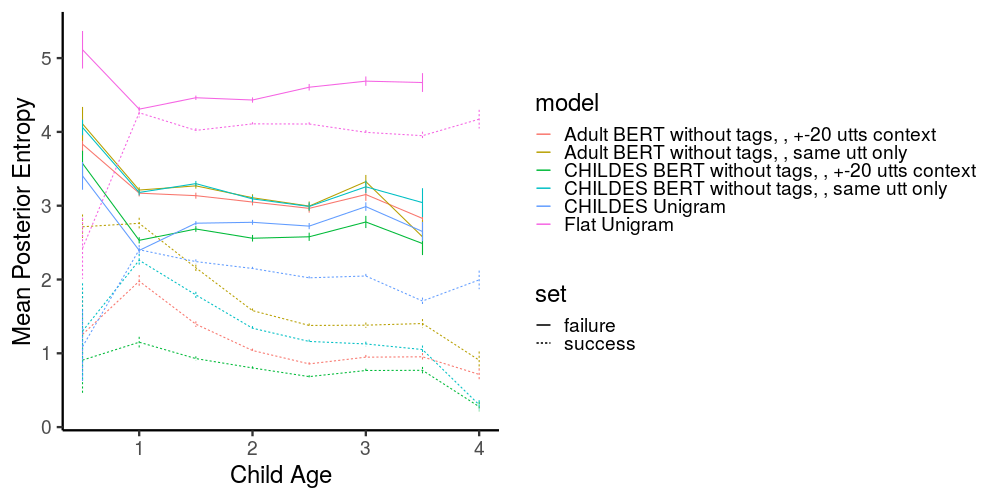

In [164]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# 11 Information Gain 

In [165]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [166]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

  age                                          model     gain   gain_sem
1 0.5   Adult BERT without tags, , +-20 utts context 15.75929 1.55176335
2 0.5       Adult BERT without tags, , same utt only 10.96785 0.51159655
3 0.5 CHILDES BERT without tags, , +-20 utts context 23.48716 4.43136584
4 0.5     CHILDES BERT without tags, , same utt only 20.78312 4.26538879
5 0.5                                CHILDES Unigram 20.37815 0.67615613
6 0.5                                   Flat Unigram 11.12379 0.06833978
  comparison age_in_months
1  posterior             6
2  posterior             6
3  posterior             6
4  posterior             6
5  posterior             6
6  posterior             6


In [167]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

[1] age           model         gain          gain_sem      comparison   
[6] age_in_months
<0 rows> (or 0-length row.names)


In [168]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

R[write to console]: Error in `[<-.data.frame`(`*tmp*`, "comparison", value = "perceptual data") : 
  replacement has 1 row, data has 0




Error in `[<-.data.frame`(`*tmp*`, "comparison", value = "perceptual data") : 
  replacement has 1 row, data has 0


In [169]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

R[write to console]: Error in kls_with_uniform_prior$comparison[kls_with_uniform_prior$comparison ==  : 
  object 'kls_with_uniform_prior' not found




Error in kls_with_uniform_prior$comparison[kls_with_uniform_prior$comparison ==  : 
  object 'kls_with_uniform_prior' not found


In [170]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

R[write to console]: Error in subset(kls_with_uniform_prior, age_in_months > 6) : 
  object 'kls_with_uniform_prior' not found




Error in subset(kls_with_uniform_prior, age_in_months > 6) : 
  object 'kls_with_uniform_prior' not found


# 12 Posterior Probability as a function of edit distance

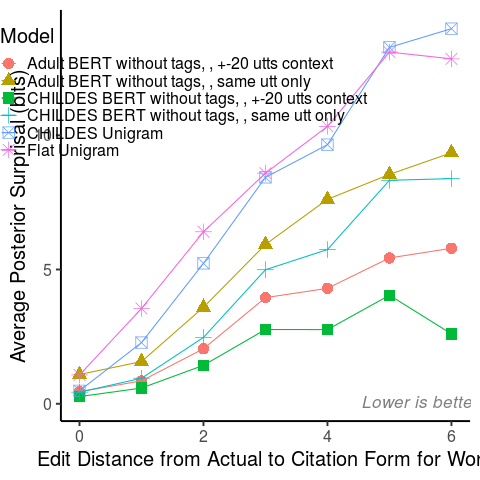

In [171]:
%%R
surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)

p1= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

In [172]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


[1] edit_distance                model                       
[3] mean_posterior_surprisal     mean_posterior_surprisal_sem
[5] high                         low                         
[7] unigram_prior_prob           multiplier                  
<0 rows> (or 0-length row.names)


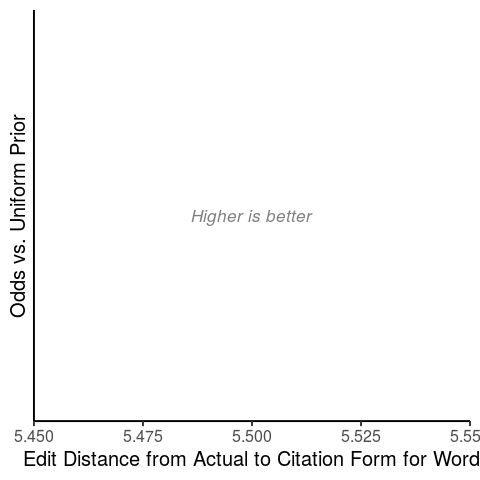

In [173]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale.pdf', height=6, width=8)    
print(p2)

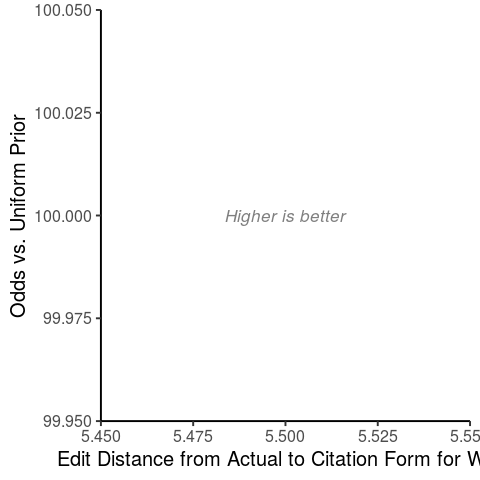

In [183]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# 13 ROC for Completions 

In [175]:
%%R
library(plotROC)

In [176]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 13434  6001


In [177]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

[1] "Adult BERT without tags, , same utt only"      
[2] "Adult BERT without tags, , +-20 utts context"  
[3] "CHILDES BERT without tags, , same utt only"    
[4] "CHILDES BERT without tags, , +-20 utts context"
[5] "Flat Unigram"                                  
[6] "CHILDES Unigram"                               


In [178]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



In [179]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 2),')')

In [180]:
%%R
scores_across_time_short$model_with_auc[1:10]

 [1] "Adult BERT without tags, , +-20 utts context (AUC = 0.86)"
 [2] "Adult BERT without tags, , +-20 utts context (AUC = 0.86)"
 [3] "Adult BERT without tags, , +-20 utts context (AUC = 0.86)"
 [4] "Adult BERT without tags, , +-20 utts context (AUC = 0.86)"
 [5] "Adult BERT without tags, , +-20 utts context (AUC = 0.86)"
 [6] "Adult BERT without tags, , +-20 utts context (AUC = 0.86)"
 [7] "Adult BERT without tags, , +-20 utts context (AUC = 0.86)"
 [8] "Adult BERT without tags, , +-20 utts context (AUC = 0.86)"
 [9] "Adult BERT without tags, , +-20 utts context (AUC = 0.86)"
[10] "Adult BERT without tags, , +-20 utts context (AUC = 0.86)"


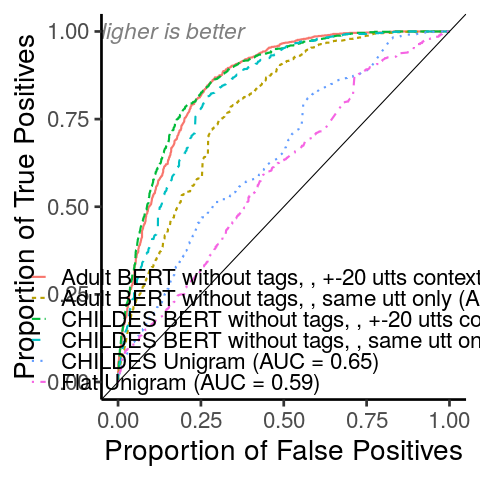

In [181]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=8, width=8)    